In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

from sklearn import preprocessing
from sklearn import impute
from sklearn import pipeline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

2023-08-08 19:18:23.885320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(2112)
tf.random.set_seed(2112)

***
## loading data

In [3]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [4]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [5]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 5

10


In [6]:
alpha_labels = ["Alpha_A", "Alpha_B", "Alpha_D", "Alpha_G"]
beta_labels = ["Beta_A","Beta_B","Beta_C"]
gamma_labels = ["Gamma_A","Gamma_B","Gamma_E","Gamma_F","Gamma_G","Gamma_H","Gamma_M","Gamma_N"]
delta_labels = ["Delta_A","Delta_B","Delta_C","Delta_D"]

In [7]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [8]:
# create sample weight column
train["weight"] = 1.
idx = train.query("Class == 1").index
train.loc[idx,"weight"] = scale_pos_weight

***
## training

In [9]:
def create_model_instance(
        hidden_size=64, 
        dropout1=0.1, 
        dropout2=0.05,
        l2_lambda=1e-3,
        label_smoothing=0.01,
        activation="relu",
    ):
    input = tf.keras.Input(shape=(56,))
    x = tf.keras.layers.Dropout(dropout1)(input)
    x = tf.keras.layers.Dense(
        hidden_size, 
        activation=activation, 
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    x = tf.keras.layers.Dropout(dropout2)(x)
    output1 = Dense(
        4, 
        activation='softmax', 
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output2 = Dense(
        3,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output3 = Dense(
        8,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output4 = Dense(
        4, 
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)

    model = tf.keras.models.Model(
        inputs=input, 
        outputs=[output1, output2, output3, output4]
    )
    model.compile(
        optimizer='adam',
        loss=[
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        ],
        loss_weights=[1., 1., 1., 1.],
    )
    return model

In [10]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

In [11]:
def train_validate(
        dataframe,
        input_cols, 
        instance_params,
        fit_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)
            
            model = create_model_instance(**instance_params)
            model.fit(
                x = train_df[input_cols].values, 
                y = [
                    train_df[alpha_labels].values, 
                    train_df[beta_labels].values, 
                    train_df[gamma_labels].values,
                    train_df[delta_labels].values,
                ], 
                sample_weight = train_df["weight"].values,
                shuffle = True,
                verbose = 0,
                **fit_params
            )
            
            out1,_,_,_ = model.predict(valid_df[input_cols].values, verbose=0)
            y_pred = out1[:,1:].sum(axis=1)

            metrics.append( balanced_logloss_(y_pred, valid_df["Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    
    instance_params = dict(
        hidden_size = trial.suggest_int("hidden_size", 128, 768, 16),
        dropout1 = trial.suggest_float("dropout1", 0.0, 0.1),
        dropout2 = trial.suggest_float("dropout2", 0.0, 0.1),
        l2_lambda = trial.suggest_float("l2_lambda", 1e-10, 1e-1, log=True),
        label_smoothing = trial.suggest_float("label_smoothing", 0.00, 0.15),
        #activation = trial.suggest_categorical("activation", ["relu","sigmoid","tanh"]), 
    ) 
    fit_params = dict(
        epochs = trial.suggest_int("epochs", 100, 400, 10), 
        batch_size = trial.suggest_int("batch_size", 8, 256, 8),
    )
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        instance_params = instance_params,
        fit_params = fit_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [12]:
%%time

instance_params = {
    "hidden_size":100,
    "dropout1":0.05,
    "dropout2":0.05,
    "l2_lambda":1e-4,
    "label_smoothing":0.01,
    "activation":"relu",
}
fit_params = {
    "epochs":100,
    "batch_size":32,
}

train_validate(
    dataframe = train,
    input_cols = input_cols,
    instance_params = instance_params,
    fit_params = fit_params,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False,
)

CPU times: user 3min 12s, sys: 31.2 s, total: 3min 43s
Wall time: 2min 16s


(0.37699935889729747, 0.07383735091246565)

In [13]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-mlp",
    direction='minimize',
    storage='sqlite:///iarc-mlp.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=28800, # 8 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-08-08 19:20:43,800] Using an existing study with name 'iarc-mlp' instead of creating a new one.


[I 2023-08-08 19:33:48,511] Trial 135 finished with value: 0.3250593311101322 and parameters: {'batch_size': 8, 'dropout1': 0.04198464951845862, 'dropout2': 0.0023938652995967504, 'epochs': 240, 'hidden_size': 544, 'l2_lambda': 7.709873188127944e-10, 'label_smoothing': 0.10658715175259506}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 19:49:33,522] Trial 136 finished with value: 0.3145010821339347 and parameters: {'batch_size': 8, 'dropout1': 0.042704881260512965, 'dropout2': 0.006267314505693274, 'epochs': 270, 'hidden_size': 752, 'l2_lambda': 1.8029603178180923e-09, 'label_smoothing': 0.10365443310549474}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 19:56:50,442] Trial 137 finished with value: 0.31591866787488554 and parameters: {'batch_size': 24, 'dropout1': 0.04714500370560502, 'dropout2': 0.0026694428353487114, 'epochs': 280, 'hidden_size': 544, 'l2_lambda': 2.650562802424344e-10, 'label_smoothing': 0.10340726293598358}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 20:01:18,272] Trial 138 finished with value: 0.32098242826449697 and parameters: {'batch_size': 40, 'dropout1': 0.04853246468103086, 'dropout2': 0.011023402484390665, 'epochs': 220, 'hidden_size': 528, 'l2_lambda': 3.9385343882321813e-10, 'label_smoothing': 0.07589995432145337}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 20:07:32,265] Trial 139 finished with value: 0.309237196541401 and parameters: {'batch_size': 24, 'dropout1': 0.04286279754635641, 'dropout2': 0.007700165132156888, 'epochs': 260, 'hidden_size': 432, 'l2_lambda': 3.6538807781069413e-09, 'label_smoothing': 0.10155269734484138}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 20:20:32,474] Trial 140 finished with value: 0.31347096772104927 and parameters: {'batch_size': 8, 'dropout1': 0.04997611224282261, 'dropout2': 0.001776270215333083, 'epochs': 240, 'hidden_size': 432, 'l2_lambda': 1.0912554050901328e-09, 'label_smoothing': 0.07418780609191551}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 20:27:02,285] Trial 141 finished with value: 0.3061055331857905 and parameters: {'batch_size': 24, 'dropout1': 0.04692314455417998, 'dropout2': 0.006513505311500892, 'epochs': 270, 'hidden_size': 528, 'l2_lambda': 5.678849775791249e-10, 'label_smoothing': 0.08111541442574809}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 20:33:43,423] Trial 142 finished with value: 0.3074478855389339 and parameters: {'batch_size': 24, 'dropout1': 0.04530161360701002, 'dropout2': 0.007209642187753171, 'epochs': 270, 'hidden_size': 544, 'l2_lambda': 5.595893341274318e-10, 'label_smoothing': 0.08090805596212047}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 20:40:34,910] Trial 143 finished with value: 0.3080350935481286 and parameters: {'batch_size': 24, 'dropout1': 0.040630276831276825, 'dropout2': 0.0068722007129802965, 'epochs': 270, 'hidden_size': 592, 'l2_lambda': 4.3548575173120217e-10, 'label_smoothing': 0.08012040799135353}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 20:47:42,874] Trial 144 finished with value: 0.3090465918355061 and parameters: {'batch_size': 24, 'dropout1': 0.04380741415022183, 'dropout2': 0.010896590672966588, 'epochs': 280, 'hidden_size': 576, 'l2_lambda': 5.608041198602775e-10, 'label_smoothing': 0.07584545814892524}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:03:46,995] Trial 145 finished with value: 0.3296022124220714 and parameters: {'batch_size': 8, 'dropout1': 0.04760920308426498, 'dropout2': 0.006124658980364299, 'epochs': 290, 'hidden_size': 576, 'l2_lambda': 2.8971960112145475e-10, 'label_smoothing': 0.0706830873153072}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:09:12,174] Trial 146 finished with value: 0.3131763928110458 and parameters: {'batch_size': 40, 'dropout1': 0.05140525664097249, 'dropout2': 0.014766152893682754, 'epochs': 270, 'hidden_size': 528, 'l2_lambda': 2.2349867866226968e-10, 'label_smoothing': 0.08185105603919055}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:15:21,769] Trial 147 finished with value: 0.31412003931690025 and parameters: {'batch_size': 24, 'dropout1': 0.03883682643245828, 'dropout2': 0.011148089009297658, 'epochs': 250, 'hidden_size': 528, 'l2_lambda': 1.5761408378332125e-09, 'label_smoothing': 0.07791710332114475}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:20:05,508] Trial 148 finished with value: 0.31817173329055537 and parameters: {'batch_size': 40, 'dropout1': 0.050143539316240715, 'dropout2': 0.0033740331724614013, 'epochs': 230, 'hidden_size': 560, 'l2_lambda': 6.005989477217077e-10, 'label_smoothing': 0.08147333422557482}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:32:23,122] Trial 149 finished with value: 0.3129510929819151 and parameters: {'batch_size': 8, 'dropout1': 0.042126199243844045, 'dropout2': 0.007338125745125734, 'epochs': 210, 'hidden_size': 608, 'l2_lambda': 3.632329954594127e-10, 'label_smoothing': 0.07274185276066718}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:39:18,753] Trial 150 finished with value: 0.3095063586380033 and parameters: {'batch_size': 24, 'dropout1': 0.04581880057151706, 'dropout2': 1.7746065471330088e-05, 'epochs': 260, 'hidden_size': 416, 'l2_lambda': 1.1502611319470417e-09, 'label_smoothing': 0.08388599475515916}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:53:59,308] Trial 151 finished with value: 0.31819342696395314 and parameters: {'batch_size': 8, 'dropout1': 0.04786769931920555, 'dropout2': 0.006132026690341013, 'epochs': 270, 'hidden_size': 464, 'l2_lambda': 2.0888538202803393e-09, 'label_smoothing': 0.0775393298318639}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 21:58:08,801] Trial 152 finished with value: 0.31503127810588016 and parameters: {'batch_size': 56, 'dropout1': 0.045253040182307275, 'dropout2': 0.0023328974401978296, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 8.580326448676189e-10, 'label_smoothing': 0.0825895618437967}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 22:04:24,988] Trial 153 finished with value: 0.30617585293763083 and parameters: {'batch_size': 24, 'dropout1': 0.041470650065440456, 'dropout2': 0.0018400025929806718, 'epochs': 250, 'hidden_size': 448, 'l2_lambda': 6.634268049291344e-10, 'label_smoothing': 0.0941711582257479}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 22:10:33,149] Trial 154 finished with value: 0.31892405477112057 and parameters: {'batch_size': 24, 'dropout1': 0.03798928392117044, 'dropout2': 0.0034502128684648493, 'epochs': 250, 'hidden_size': 512, 'l2_lambda': 4.885097073613408e-10, 'label_smoothing': 0.09546583396400374}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 22:15:09,847] Trial 155 finished with value: 0.3123739606454249 and parameters: {'batch_size': 40, 'dropout1': 0.053274109394271615, 'dropout2': 0.018874850253890144, 'epochs': 240, 'hidden_size': 416, 'l2_lambda': 2.6294653927557497e-10, 'label_smoothing': 0.08517511222333475}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 22:21:18,976] Trial 156 finished with value: 0.31474603086509506 and parameters: {'batch_size': 24, 'dropout1': 0.043441707899087724, 'dropout2': 0.010804342935910198, 'epochs': 250, 'hidden_size': 464, 'l2_lambda': 1.8023386881012742e-10, 'label_smoothing': 0.0991931050716138}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 22:35:42,991] Trial 157 finished with value: 0.3097755967645622 and parameters: {'batch_size': 8, 'dropout1': 0.040841652840128875, 'dropout2': 0.00785535904136624, 'epochs': 270, 'hidden_size': 448, 'l2_lambda': 5.954334087823836e-10, 'label_smoothing': 0.0892361815536801}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 22:41:34,190] Trial 158 finished with value: 0.3117472998604979 and parameters: {'batch_size': 24, 'dropout1': 0.03251672460956431, 'dropout2': 0.014303853212513139, 'epochs': 230, 'hidden_size': 432, 'l2_lambda': 1.1153390714971452e-10, 'label_smoothing': 0.08018070819510152}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 22:55:23,165] Trial 159 finished with value: 0.32499539013286693 and parameters: {'batch_size': 8, 'dropout1': 0.03650124537062111, 'dropout2': 0.005134848481954153, 'epochs': 240, 'hidden_size': 624, 'l2_lambda': 3.844624335199399e-10, 'label_smoothing': 0.08576815203981555}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:02:06,673] Trial 160 finished with value: 0.31267377613694985 and parameters: {'batch_size': 24, 'dropout1': 0.03909613979442494, 'dropout2': 0.003771318863590535, 'epochs': 280, 'hidden_size': 464, 'l2_lambda': 9.33686111737713e-06, 'label_smoothing': 0.09426189479073496}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:06:49,681] Trial 161 finished with value: 0.3177199510618774 and parameters: {'batch_size': 40, 'dropout1': 0.04978837205967583, 'dropout2': 8.057839701187787e-05, 'epochs': 250, 'hidden_size': 400, 'l2_lambda': 1.304672753426249e-09, 'label_smoothing': 0.09049415889840291}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:10:20,777] Trial 162 finished with value: 0.32186732489594205 and parameters: {'batch_size': 88, 'dropout1': 0.04638009184592767, 'dropout2': 0.002365605001722352, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 8.724047994939508e-10, 'label_smoothing': 0.09125728813266176}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:14:32,493] Trial 163 finished with value: 0.31364015366705017 and parameters: {'batch_size': 56, 'dropout1': 0.04175751995366043, 'dropout2': 3.745351913283059e-06, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 8.245445496034454e-10, 'label_smoothing': 0.0936752442701603}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:21:00,062] Trial 164 finished with value: 0.3052085656922073 and parameters: {'batch_size': 24, 'dropout1': 0.045497041313687016, 'dropout2': 0.0058485792051311165, 'epochs': 270, 'hidden_size': 480, 'l2_lambda': 1.986838259283508e-10, 'label_smoothing': 0.08397330372928094}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:27:35,466] Trial 165 finished with value: 0.30923103152561227 and parameters: {'batch_size': 24, 'dropout1': 0.043427093604485364, 'dropout2': 0.006183912591939809, 'epochs': 270, 'hidden_size': 480, 'l2_lambda': 1.9455949274875044e-10, 'label_smoothing': 0.08390853931037298}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:43:00,357] Trial 166 finished with value: 0.33476145046171046 and parameters: {'batch_size': 8, 'dropout1': 0.048249968249606215, 'dropout2': 0.017702118311200016, 'epochs': 280, 'hidden_size': 496, 'l2_lambda': 1.0269182789643884e-10, 'label_smoothing': 0.07858436151561678}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:45:49,870] Trial 167 finished with value: 0.33918166997076327 and parameters: {'batch_size': 144, 'dropout1': 0.05517564867637577, 'dropout2': 0.008248003660523959, 'epochs': 240, 'hidden_size': 416, 'l2_lambda': 3.1277543729334296e-10, 'label_smoothing': 0.086949123853183}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:51:39,883] Trial 168 finished with value: 0.3136084458404299 and parameters: {'batch_size': 24, 'dropout1': 0.05160344410448702, 'dropout2': 0.0048311143302701585, 'epochs': 230, 'hidden_size': 480, 'l2_lambda': 4.741804645143798e-10, 'label_smoothing': 0.0753708529099689}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 23:58:44,765] Trial 169 finished with value: 0.3192298846979287 and parameters: {'batch_size': 24, 'dropout1': 0.04509167607666816, 'dropout2': 0.012112313438937783, 'epochs': 290, 'hidden_size': 512, 'l2_lambda': 1.86010941624016e-10, 'label_smoothing': 0.08162913673249389}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 00:03:49,902] Trial 170 finished with value: 0.313235395629965 and parameters: {'batch_size': 40, 'dropout1': 0.039701472049010714, 'dropout2': 0.014417886382010145, 'epochs': 270, 'hidden_size': 464, 'l2_lambda': 2.8502871228005164e-10, 'label_smoothing': 0.08823744247878568}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 00:16:41,213] Trial 171 finished with value: 0.313342958402204 and parameters: {'batch_size': 8, 'dropout1': 0.052855666688722984, 'dropout2': 0.010753845451978522, 'epochs': 250, 'hidden_size': 208, 'l2_lambda': 2.628334700623353e-09, 'label_smoothing': 0.09681568141618413}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 00:23:00,387] Trial 172 finished with value: 0.30723395281686483 and parameters: {'batch_size': 24, 'dropout1': 0.046668866386411594, 'dropout2': 0.002508402010348233, 'epochs': 260, 'hidden_size': 432, 'l2_lambda': 6.33343991847139e-10, 'label_smoothing': 0.0907339782995132}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 00:29:21,141] Trial 173 finished with value: 0.3078926415570766 and parameters: {'batch_size': 24, 'dropout1': 0.04811654113951052, 'dropout2': 0.002885031021534818, 'epochs': 260, 'hidden_size': 432, 'l2_lambda': 6.000265065118834e-10, 'label_smoothing': 0.08465633233344852}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 00:35:55,058] Trial 174 finished with value: 0.30869452117023494 and parameters: {'batch_size': 24, 'dropout1': 0.04414685219728171, 'dropout2': 0.007943385860987265, 'epochs': 270, 'hidden_size': 464, 'l2_lambda': 3.8717651466412237e-10, 'label_smoothing': 0.08869912540614394}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 00:49:20,668] Trial 175 finished with value: 0.3059082473327056 and parameters: {'batch_size': 8, 'dropout1': 0.0417146055934449, 'dropout2': 0.0041587345293472855, 'epochs': 250, 'hidden_size': 432, 'l2_lambda': 1.692048198390185e-09, 'label_smoothing': 0.09171869240706956}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 01:03:12,144] Trial 176 finished with value: 0.3108457229377011 and parameters: {'batch_size': 8, 'dropout1': 0.04173564198911908, 'dropout2': 0.0017565343510850722, 'epochs': 250, 'hidden_size': 432, 'l2_lambda': 2.030002481494492e-07, 'label_smoothing': 0.10122712269074342}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 01:15:59,481] Trial 177 finished with value: 0.3207521396195618 and parameters: {'batch_size': 8, 'dropout1': 0.036263502774044505, 'dropout2': 0.004350711693872823, 'epochs': 240, 'hidden_size': 400, 'l2_lambda': 1.4396682799454212e-09, 'label_smoothing': 0.09213070530278739}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 01:28:22,859] Trial 178 finished with value: 0.3080841303512364 and parameters: {'batch_size': 8, 'dropout1': 0.0385652846607991, 'dropout2': 0.022447409631190726, 'epochs': 220, 'hidden_size': 416, 'l2_lambda': 1.8952880481630843e-10, 'label_smoothing': 0.09732724612746185}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 01:34:52,110] Trial 179 finished with value: 0.3058796848335541 and parameters: {'batch_size': 24, 'dropout1': 0.05014965601604611, 'dropout2': 0.0055887887866764565, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 3.772403242341589e-09, 'label_smoothing': 0.08979203972111637}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 01:39:20,068] Trial 180 finished with value: 0.3105465166739127 and parameters: {'batch_size': 40, 'dropout1': 0.049946535832847874, 'dropout2': 0.009347743876046661, 'epochs': 230, 'hidden_size': 448, 'l2_lambda': 6.412199932375476e-09, 'label_smoothing': 0.08707100931793198}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 01:53:39,447] Trial 181 finished with value: 0.3094819283848361 and parameters: {'batch_size': 8, 'dropout1': 0.033529409336070085, 'dropout2': 0.005798791863532438, 'epochs': 250, 'hidden_size': 480, 'l2_lambda': 2.0078157973184042e-09, 'label_smoothing': 0.09426109015309139}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:00:09,236] Trial 182 finished with value: 0.3150469174977664 and parameters: {'batch_size': 24, 'dropout1': 0.046931632063143026, 'dropout2': 0.0035164621477905933, 'epochs': 260, 'hidden_size': 464, 'l2_lambda': 3.964974093071687e-09, 'label_smoothing': 0.09024223492206299}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:03:09,695] Trial 183 finished with value: 0.333129478079549 and parameters: {'batch_size': 24, 'dropout1': 0.041503256779172576, 'dropout2': 0.002622591461530103, 'epochs': 100, 'hidden_size': 432, 'l2_lambda': 1.1655493044669378e-09, 'label_smoothing': 0.08430047265323076}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:06:39,017] Trial 184 finished with value: 0.3361180879472936 and parameters: {'batch_size': 120, 'dropout1': 0.04978883467153913, 'dropout2': 0.005787374478357548, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 7.429908581067033e-10, 'label_smoothing': 0.09090394774899262}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:12:56,672] Trial 185 finished with value: 0.3091212595313068 and parameters: {'batch_size': 24, 'dropout1': 0.035293156379515495, 'dropout2': 0.0012547853598606357, 'epochs': 250, 'hidden_size': 432, 'l2_lambda': 2.8872207281027735e-10, 'label_smoothing': 0.08789174853139593}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:26:00,332] Trial 186 finished with value: 0.3144835519648543 and parameters: {'batch_size': 8, 'dropout1': 0.030914759832318277, 'dropout2': 0.01600028703835136, 'epochs': 240, 'hidden_size': 416, 'l2_lambda': 1.0940371127506324e-09, 'label_smoothing': 0.09376301500977649}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:32:26,810] Trial 187 finished with value: 0.3123030638290145 and parameters: {'batch_size': 24, 'dropout1': 0.05176878730803616, 'dropout2': 0.004518237886583111, 'epochs': 260, 'hidden_size': 480, 'l2_lambda': 2.0824948163150423e-08, 'label_smoothing': 0.09756287465189328}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:37:40,051] Trial 188 finished with value: 0.31909436858783297 and parameters: {'batch_size': 40, 'dropout1': 0.043998772597149315, 'dropout2': 0.019082192259264514, 'epochs': 280, 'hidden_size': 464, 'l2_lambda': 4.1092015500472654e-10, 'label_smoothing': 0.08547752483919761}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:44:03,805] Trial 189 finished with value: 0.3174372467042875 and parameters: {'batch_size': 24, 'dropout1': 0.05451525845937736, 'dropout2': 0.009842828222449126, 'epochs': 250, 'hidden_size': 496, 'l2_lambda': 1.6889667895774573e-09, 'label_smoothing': 0.09046828651972919}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 02:57:22,701] Trial 190 finished with value: 0.311635472282158 and parameters: {'batch_size': 8, 'dropout1': 0.047349430527096566, 'dropout2': 0.032381326112061064, 'epochs': 240, 'hidden_size': 416, 'l2_lambda': 1.5100267736683623e-10, 'label_smoothing': 0.0832534621173321}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 03:03:37,743] Trial 191 finished with value: 0.30960708299006506 and parameters: {'batch_size': 24, 'dropout1': 0.03854445437046077, 'dropout2': 0.02881300820402006, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 6.741519894639818e-10, 'label_smoothing': 0.1324126238315671}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 03:10:32,013] Trial 192 finished with value: 0.3057670888898166 and parameters: {'batch_size': 24, 'dropout1': 0.04612710731683417, 'dropout2': 0.007190048482513787, 'epochs': 270, 'hidden_size': 544, 'l2_lambda': 5.82753839357103e-10, 'label_smoothing': 0.07946958055488966}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 03:16:27,052] Trial 193 finished with value: 0.3112420595835624 and parameters: {'batch_size': 32, 'dropout1': 0.045751945803208405, 'dropout2': 0.00702365358926727, 'epochs': 270, 'hidden_size': 464, 'l2_lambda': 2.7545670885792995e-10, 'label_smoothing': 0.07920163420694347}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-09 03:23:12,861] Trial 194 finished with value: 0.30999474304214397 and parameters: {'batch_size': 24, 'dropout1': 0.040553559644265595, 'dropout2': 0.001725989814546405, 'epochs': 280, 'hidden_size': 432, 'l2_lambda': 4.759956247395013e-10, 'label_smoothing': 0.08800361356853753}. Best is trial 100 with value: 0.2999847415633719.


In [14]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout1,params_dropout2,params_epochs,params_hidden_size,params_l2_lambda,params_label_smoothing,state
100,100,0.299985,2023-08-08 14:31:04.621199,2023-08-08 14:38:51.934872,0 days 00:07:47.313673,16,0.039827,0.004262,250,448,6.674364e-10,0.088985,COMPLETE
74,74,0.302613,2023-08-08 11:47:49.669123,2023-08-08 11:55:38.146145,0 days 00:07:48.477022,16,0.048601,0.037945,260,304,7.737044e-10,0.083640,COMPLETE
123,123,0.303787,2023-08-08 17:09:01.412458,2023-08-08 17:16:19.666292,0 days 00:07:18.253834,16,0.036123,0.012323,230,448,1.257948e-10,0.088114,COMPLETE
124,124,0.304804,2023-08-08 17:16:20.348177,2023-08-08 17:23:03.321345,0 days 00:06:42.973168,16,0.023944,0.012493,210,448,2.930405e-10,0.082355,COMPLETE
164,164,0.305209,2023-08-08 23:14:33.286887,2023-08-08 23:21:00.042338,0 days 00:06:26.755451,24,0.045497,0.005849,270,480,1.986838e-10,0.083973,COMPLETE
109,109,0.305609,2023-08-08 15:35:09.885910,2023-08-08 15:43:04.166870,0 days 00:07:54.280960,16,0.035688,0.003896,250,464,1.419457e-10,0.086677,COMPLETE
72,72,0.305746,2023-08-08 11:34:33.200686,2023-08-08 11:41:47.131089,0 days 00:07:13.930403,16,0.051892,0.021180,230,384,8.501264e-10,0.087223,COMPLETE
128,128,0.305747,2023-08-08 17:40:32.904242,2023-08-08 17:46:04.261026,0 days 00:05:31.356784,32,0.047899,0.003269,260,448,7.896306e-10,0.092287,COMPLETE
192,192,0.305767,2023-08-09 03:03:38.519710,2023-08-09 03:10:31.993237,0 days 00:06:53.473527,24,0.046127,0.007190,270,544,5.827538e-10,0.079470,COMPLETE
179,179,0.305880,2023-08-09 01:28:23.692701,2023-08-09 01:34:52.090918,0 days 00:06:28.398217,24,0.050150,0.005589,260,448,3.772403e-09,0.089792,COMPLETE


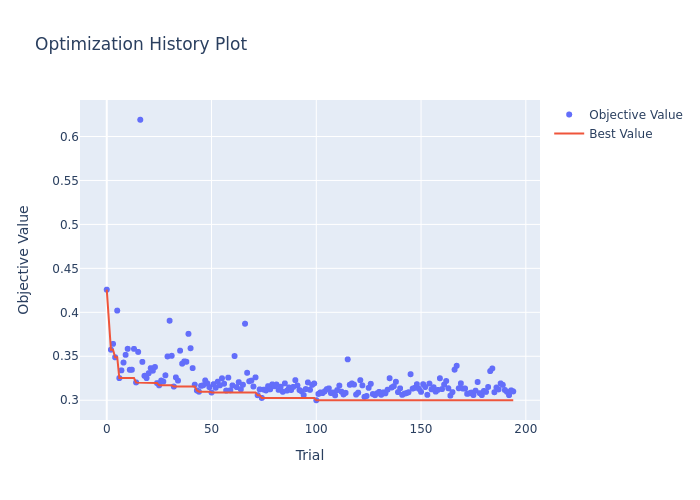

In [15]:
plot_optimization_history(study)

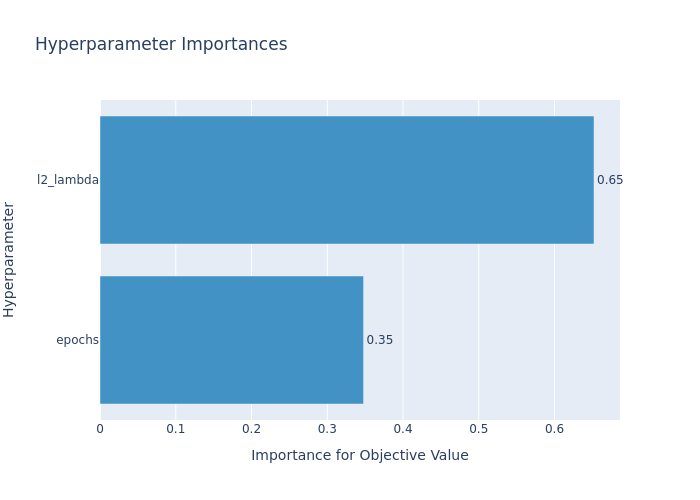

In [16]:
plot_param_importances(study)

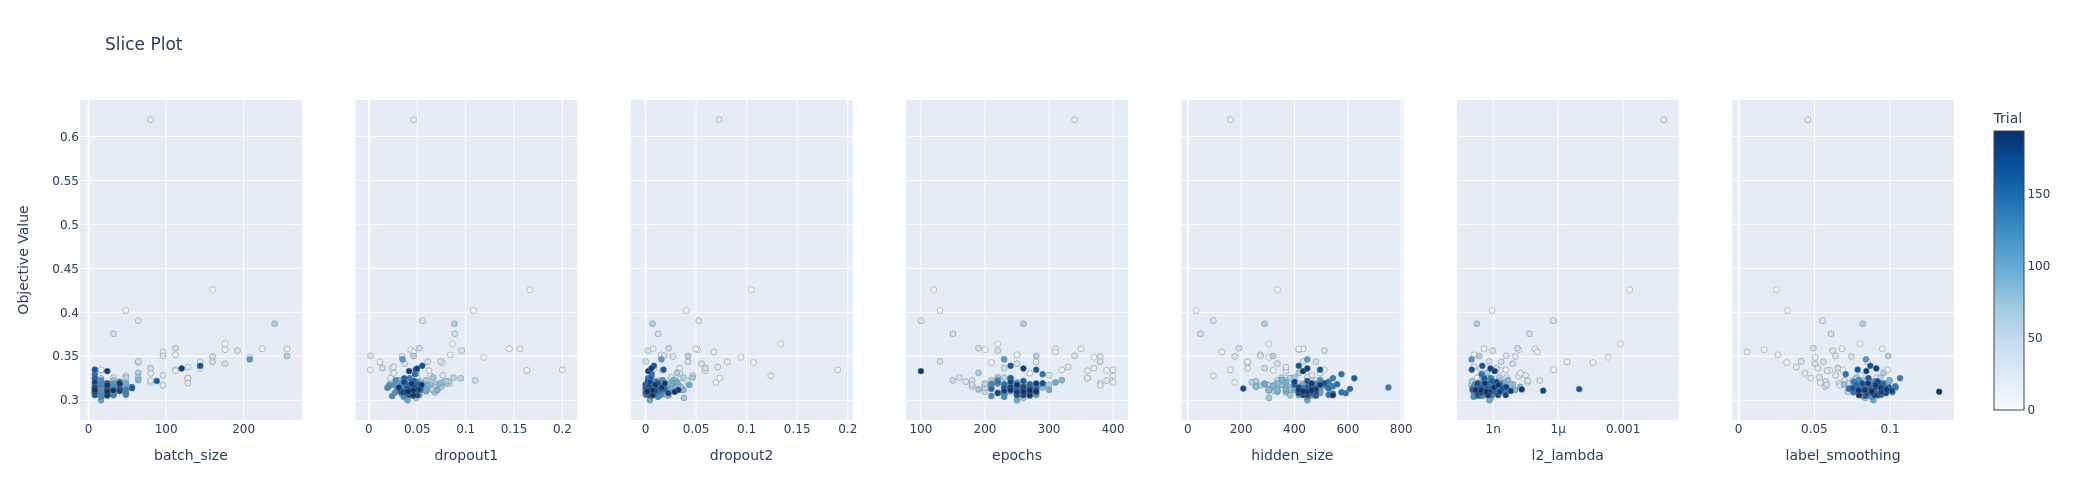

In [17]:
plot_slice(study)

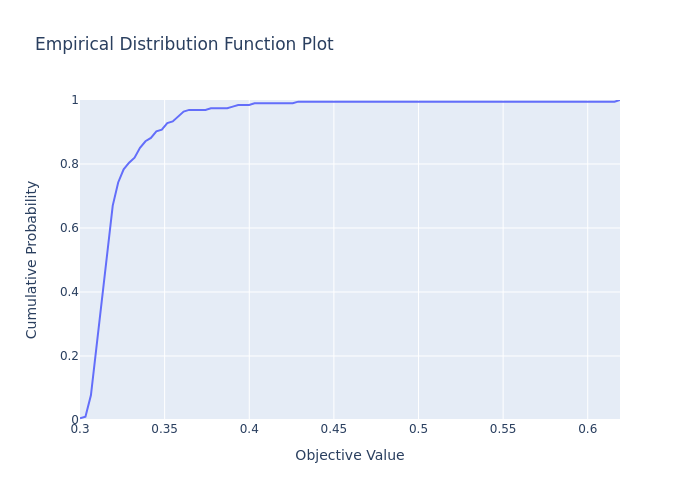

In [18]:
plot_edf(study)

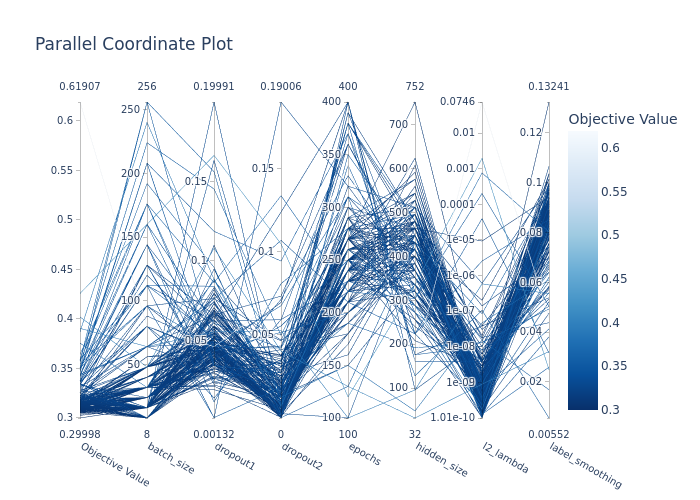

In [19]:
plot_parallel_coordinate(study)

In [20]:
best_params = dict(study.best_params)
best_params

{'batch_size': 16,
 'dropout1': 0.03982678862783072,
 'dropout2': 0.004262334659007105,
 'epochs': 250,
 'hidden_size': 448,
 'l2_lambda': 6.67436447730217e-10,
 'label_smoothing': 0.08898495026155208}

***